In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils import load_data, stack_windowed_data
from dataset_loaders import create_dataloaders
from models import CNNModel
from train import train
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json

device = 'cuda'

import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [58]:
data = load_data(file_path='data/W_AUGMENTED_DATA.json')
sequences, labels = stack_windowed_data(data)
train_loader, val_loader, test_loader, class_weights = create_dataloaders(sequences, labels, batch_size=32,
                                                                          return_class_weights=True,
                                                                          verbose=False)

In [59]:
model = torch.load('models/weights/cnn.pt', map_location=device)

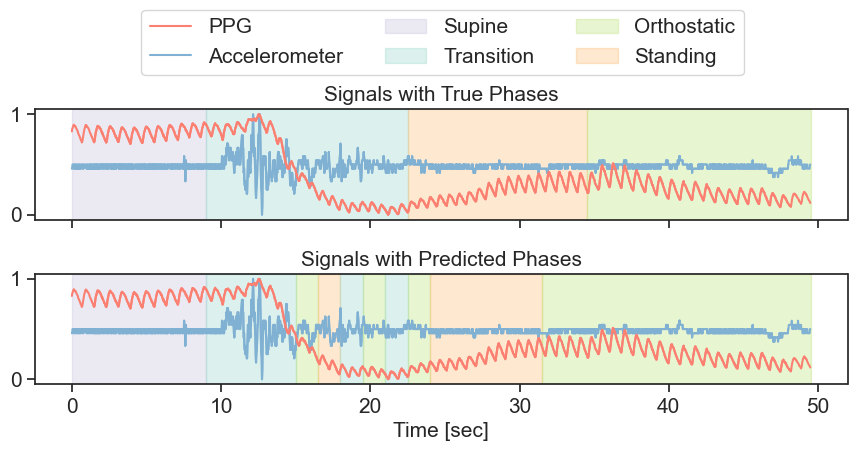

In [60]:
import matplotlib.pyplot as plt
import numpy as np

fs = 50
step_size = 75
window_size = 150

palette = sns.color_palette("Set3")
colors = [palette[i] for i in [3, 3, 4, 2, 0, 5, 6]]
labels_names = ['Supine', 'Transition', 'Standing', 'Orthostatic']
saved = False

def group_segments(labels):
    segments = []
    start_idx = 0
    for i in range(1, len(labels)):
        if labels[i] != labels[i-1]:
            segments.append((start_idx, i-1))
            start_idx = i
    # Add the last segment
    segments.append((start_idx, len(labels) - 1))
    return segments

saved_plot = False
for padded_sequences, lengths, labels in test_loader:
    padded_sequences = padded_sequences[:, :, :3]
    batch_outputs = model(padded_sequences.float().to(device), lengths)
    _, predicted = torch.max(batch_outputs.view(-1, 4), 1)
    for record_num in range(len(padded_sequences)):   # range(len(padded_sequences)):
        added_labels = set()
        current_len = lengths[record_num]
        sequence, true_labels, prediction = padded_sequences[record_num][:current_len], labels[record_num][:current_len], predicted[record_num * 58: record_num*58+58][:current_len].cpu()
        if record_num != 19:
            continue
        
        fig, axs = plt.subplots(nrows=2, figsize=(9, 4), sharex=True)  # Create a subplot for each signal
        
        for i, window in enumerate(sequence):
            start_index = i * step_size
            end_index = start_index + window_size
            time_indicies = np.arange(start_index, end_index)
            for j, plot_label in enumerate(['PPG', 'HR', 'Accelerometer']):
                if j == 1:
                    continue
                axs[0].plot(time_indicies, window[j, :], label=plot_label, color=colors[j], zorder=10 - j)
        
        axs[0].set_title('Signals with True Phases')

        grouped_segments = group_segments(true_labels)
        for start, end in group_segments(true_labels):
            plot_label = labels_names[true_labels[start]]
            if end == grouped_segments[-1][-1]:
                axs[0].axvspan(start * step_size, end * step_size + window_size, color=colors[sequence.shape[1] + true_labels[start]], alpha=0.3, label=plot_label)
            else:
                axs[0].axvspan(start * step_size, end * step_size + step_size, color=colors[sequence.shape[1] + true_labels[start]], alpha=0.3, label=plot_label)
            
        for i, window in enumerate(sequence):
            start_index = i * step_size
            end_index = start_index + window_size
            time_indicies = np.arange(start_index, end_index)
            for j, plot_label in enumerate(['PPG', 'HR', 'Accelerometer']):
                if j == 1:
                    continue
                axs[1].plot(time_indicies, window[j, :], label=plot_label, color=colors[j], zorder=10 - j)
     
        axs[1].set_title('Signals with Predicted Phases')
        grouped_segments = group_segments(prediction)
        for start, end in grouped_segments:
            plot_label = labels_names[prediction[start]]
            if end == grouped_segments[-1][-1]:
                axs[1].axvspan(start * step_size, end * step_size + window_size, color=colors[sequence.shape[1] + prediction[start]], alpha=0.3, label=plot_label)
            else:
                axs[1].axvspan(start * step_size, end * step_size + step_size, color=colors[sequence.shape[1] + prediction[start]], alpha=0.3, label=plot_label)
        
        handles, labels_legend = axs[1].get_legend_handles_labels()
        by_label_true = dict(zip(labels_legend, handles))
        handles, labels_legend = axs[1].get_legend_handles_labels()
        by_label_pred = dict(zip(labels_legend, handles))
        by_label = by_label_true | by_label_pred
        fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.525, 1.16), ncol=3)
        
        plt.xlabel('Time [sec]')
        plt.tight_layout()
        # if record_num == 20 and not saved:
        #     plt.savefig('cool-unilstm-classification-2.png', bbox_inches='tight')
        #     saved = True
        if record_num == 19 and not saved_plot:
            ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / fs))
            axs[0].xaxis.set_major_formatter(ticks)
            axs[1].xaxis.set_major_formatter(ticks)
            plt.savefig('classification-examples/cnn-class.png', bbox_inches='tight')
            plt.show()
            break


## Hybrid

In [61]:
model = torch.load('models/weights/hybrid.pt', map_location=device)

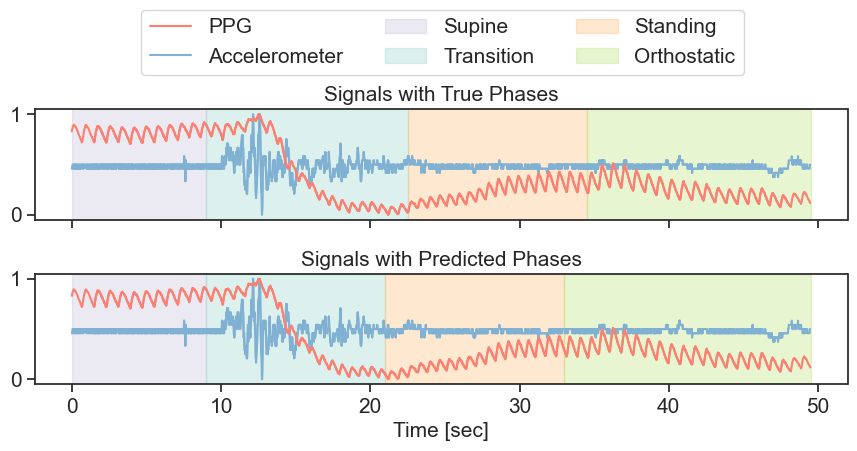

In [62]:
import matplotlib.pyplot as plt
import numpy as np

fs = 50
step_size = 75
window_size = 150

palette = sns.color_palette("Set3")
colors = [palette[i] for i in [3, 3, 4, 2, 0, 5, 6]]
labels_names = ['Supine', 'Transition', 'Standing', 'Orthostatic']
saved = False

def group_segments(labels):
    segments = []
    start_idx = 0
    for i in range(1, len(labels)):
        if labels[i] != labels[i-1]:
            segments.append((start_idx, i-1))
            start_idx = i
    # Add the last segment
    segments.append((start_idx, len(labels) - 1))
    return segments

saved_plot = False
for padded_sequences, lengths, labels in test_loader:
    padded_sequences = padded_sequences[:, :, :3]
    batch_outputs = model(padded_sequences.float().to(device), lengths)
    _, predicted = torch.max(batch_outputs.view(-1, 4), 1)
    for record_num in range(len(padded_sequences)):   # range(len(padded_sequences)):
        added_labels = set()
        current_len = lengths[record_num]
        sequence, true_labels, prediction = padded_sequences[record_num][:current_len], labels[record_num][:current_len], predicted[record_num * 58: record_num*58+58][:current_len].cpu()
        if record_num != 19:
            continue
        
        fig, axs = plt.subplots(nrows=2, figsize=(9, 4), sharex=True)  # Create a subplot for each signal
        
        for i, window in enumerate(sequence):
            start_index = i * step_size
            end_index = start_index + window_size
            time_indicies = np.arange(start_index, end_index)
            for j, plot_label in enumerate(['PPG', 'HR', 'Accelerometer']):
                if j == 1:
                    continue
                axs[0].plot(time_indicies, window[j, :], label=plot_label, color=colors[j], zorder=10 - j)
        
        axs[0].set_title('Signals with True Phases')

        grouped_segments = group_segments(true_labels)
        for start, end in group_segments(true_labels):
            plot_label = labels_names[true_labels[start]]
            if end == grouped_segments[-1][-1]:
                axs[0].axvspan(start * step_size, end * step_size + window_size, color=colors[sequence.shape[1] + true_labels[start]], alpha=0.3, label=plot_label)
            else:
                axs[0].axvspan(start * step_size, end * step_size + step_size, color=colors[sequence.shape[1] + true_labels[start]], alpha=0.3, label=plot_label)
            
        for i, window in enumerate(sequence):
            start_index = i * step_size
            end_index = start_index + window_size
            time_indicies = np.arange(start_index, end_index)
            for j, plot_label in enumerate(['PPG', 'HR', 'Accelerometer']):
                if j == 1:
                    continue
                axs[1].plot(time_indicies, window[j, :], label=plot_label, color=colors[j], zorder=10 - j)
     
        axs[1].set_title('Signals with Predicted Phases')
        grouped_segments = group_segments(prediction)
        for start, end in grouped_segments:
            plot_label = labels_names[prediction[start]]
            if end == grouped_segments[-1][-1]:
                axs[1].axvspan(start * step_size, end * step_size + window_size, color=colors[sequence.shape[1] + prediction[start]], alpha=0.3, label=plot_label)
            else:
                axs[1].axvspan(start * step_size, end * step_size + step_size, color=colors[sequence.shape[1] + prediction[start]], alpha=0.3, label=plot_label)
        
        handles, labels_legend = axs[1].get_legend_handles_labels()
        by_label_true = dict(zip(labels_legend, handles))
        handles, labels_legend = axs[1].get_legend_handles_labels()
        by_label_pred = dict(zip(labels_legend, handles))
        by_label = by_label_true | by_label_pred
        fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.525, 1.16), ncol=3)
        
        plt.xlabel('Time [sec]')
        plt.tight_layout()
        # if record_num == 20 and not saved:
        #     plt.savefig('cool-unilstm-classification-2.png', bbox_inches='tight')
        #     saved = True
        if record_num == 19 and not saved_plot:
            ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / fs))
            axs[0].xaxis.set_major_formatter(ticks)
            axs[1].xaxis.set_major_formatter(ticks)
            plt.savefig('classification-examples/hybrid-class.png', bbox_inches='tight')
            plt.show()
            break


## UniLSTM

In [63]:
from utils import stack_data

data = load_data(file_path='data/W_AUGMENTED_DATA.json')
sequences, labels = stack_data(data)
train_loader, val_loader, test_loader, class_weights = create_dataloaders(sequences, labels, batch_size=64,
                                                                          return_class_weights=True,
                                                                          verbose=False)

In [64]:
model = torch.load('models/weights/unilstm.pt', map_location=device)

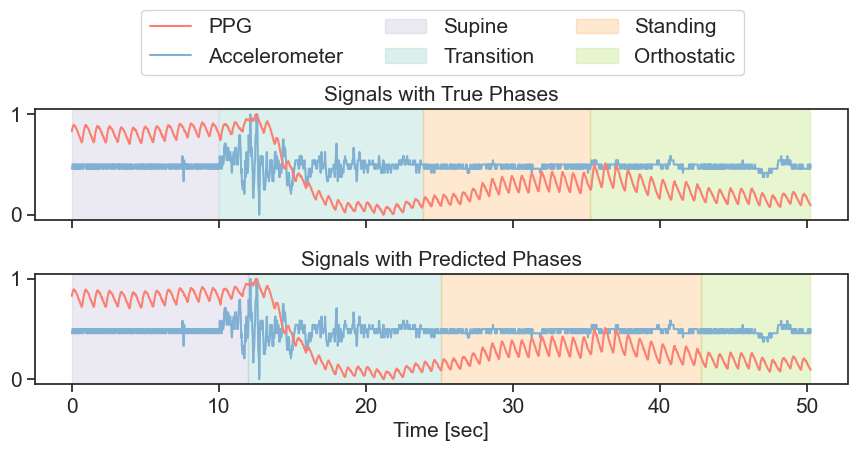

In [65]:
import matplotlib.pyplot as plt
import numpy as np

fs = 50

palette = sns.color_palette("Set3")
colors = [palette[i] for i in [3, 3, 4, 2, 0, 5, 6]]
labels_names = ['Supine', 'Transition', 'Standing', 'Orthostatic']
saved = False

def group_segments(labels):
    segments = []
    start_idx = 0
    for i in range(1, len(labels)):
        if labels[i] != labels[i-1]:
            segments.append((start_idx, i-1))
            start_idx = i
    # Add the last segment
    segments.append((start_idx, len(labels) - 1))
    return segments

saved_plot = False
for padded_sequences, lengths, labels in test_loader:
    padded_sequences = padded_sequences[:, :, :3]
    batch_outputs = model(padded_sequences.float().to(device), lengths)
    _, predicted = torch.max(batch_outputs.view(-1, 4), 1)
    for record_num in range(len(padded_sequences)):   # range(len(padded_sequences)):
        added_labels = set()
        current_len = lengths[record_num]
        sequence, true_labels, prediction = padded_sequences[record_num][:current_len], labels[record_num][:current_len], predicted[:current_len].cpu()
        if record_num != 20:
            continue
        # print('-'*20, 'record num', record_num)
        
        fig, axs = plt.subplots(nrows=2, figsize=(9, 4), sharex=True)  # Create a subplot for each signal
        
        time_indicies = np.linspace(0, len(sequence), len(sequence))
        for j, plot_label in enumerate(['PPG', 'HR', 'Accelerometer']):
            if j == 1:
                continue
            axs[0].plot(time_indicies, sequence[:, j], label=plot_label, color=colors[j], zorder=10 - j)
        
        axs[0].set_title('Signals with True Phases')

        grouped_segments = group_segments(true_labels)
        for start, end in group_segments(true_labels):
            plot_label = labels_names[true_labels[start]]
            axs[0].axvspan(start, end, color=colors[sequence.shape[1] + true_labels[start]], alpha=0.3, label=plot_label)
            
        for j, plot_label in enumerate(['PPG', 'HR', 'Accelerometer']):
            if j == 1:
                continue
            axs[1].plot(time_indicies, sequence[:, j], label=plot_label, color=colors[j], zorder=10 - j)
        
        axs[1].set_title('Signals with Predicted Phases')
        grouped_segments = group_segments(prediction)
        for start, end in grouped_segments:
            plot_label = labels_names[prediction[start]]
            axs[1].axvspan(start, end, color=colors[sequence.shape[1] + prediction[start]], alpha=0.3, label=plot_label)
            
            
        handles, labels_legend = axs[1].get_legend_handles_labels()
        by_label_true = dict(zip(labels_legend, handles))
        handles, labels_legend = axs[1].get_legend_handles_labels()
        by_label_pred = dict(zip(labels_legend, handles))
        by_label = by_label_true | by_label_pred
        fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.525, 1.16), ncol=3)
        
        plt.xlabel('Time [sec]')
        plt.tight_layout()
        # if record_num == 20 and not saved:
        #     plt.savefig('cool-unilstm-classification-2.png', bbox_inches='tight')
        #     saved = True
        if record_num == 20 and not saved_plot:
            ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / fs))
            axs[0].xaxis.set_major_formatter(ticks)
            axs[1].xaxis.set_major_formatter(ticks)
            
            plt.savefig('classification-examples/unilstm-class.png', bbox_inches='tight')
            plt.show()
            break
        # plt.show()


## Bilistm

In [66]:
model = torch.load('models/weights/bilstm.pt', map_location=device)

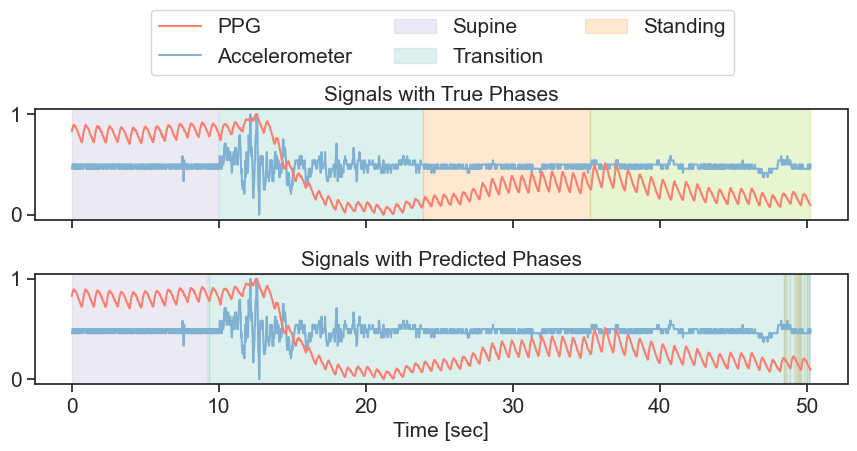

In [67]:
import matplotlib.pyplot as plt
import numpy as np

fs = 50

palette = sns.color_palette("Set3")
colors = [palette[i] for i in [3, 3, 4, 2, 0, 5, 6]]
labels_names = ['Supine', 'Transition', 'Standing', 'Orthostatic']
saved = False

def group_segments(labels):
    segments = []
    start_idx = 0
    for i in range(1, len(labels)):
        if labels[i] != labels[i-1]:
            segments.append((start_idx, i-1))
            start_idx = i
    # Add the last segment
    segments.append((start_idx, len(labels) - 1))
    return segments

saved_plot = False
for padded_sequences, lengths, labels in test_loader:
    padded_sequences = padded_sequences[:, :, :3]
    batch_outputs = model(padded_sequences.float().to(device), lengths)
    _, predicted = torch.max(batch_outputs.view(-1, 4), 1)
    for record_num in range(len(padded_sequences)):   # range(len(padded_sequences)):
        added_labels = set()
        current_len = lengths[record_num]
        sequence, true_labels, prediction = padded_sequences[record_num][:current_len], labels[record_num][:current_len], predicted[:current_len].cpu()
        if record_num != 20:
            continue
        # print('-'*20, 'record num', record_num)
        
        fig, axs = plt.subplots(nrows=2, figsize=(9, 4), sharex=True)  # Create a subplot for each signal
        
        time_indicies = np.linspace(0, len(sequence), len(sequence))
        for j, plot_label in enumerate(['PPG', 'HR', 'Accelerometer']):
            if j == 1:
                continue
            axs[0].plot(time_indicies, sequence[:, j], label=plot_label, color=colors[j], zorder=10 - j)
        
        axs[0].set_title('Signals with True Phases')

        grouped_segments = group_segments(true_labels)
        for start, end in group_segments(true_labels):
            plot_label = labels_names[true_labels[start]]
            axs[0].axvspan(start, end, color=colors[sequence.shape[1] + true_labels[start]], alpha=0.3, label=plot_label)
            
        for j, plot_label in enumerate(['PPG', 'HR', 'Accelerometer']):
            if j == 1:
                continue
            axs[1].plot(time_indicies, sequence[:, j], label=plot_label, color=colors[j], zorder=10 - j)
        
        axs[1].set_title('Signals with Predicted Phases')
        grouped_segments = group_segments(prediction)
        for start, end in grouped_segments:
            plot_label = labels_names[prediction[start]]
            axs[1].axvspan(start, end, color=colors[sequence.shape[1] + prediction[start]], alpha=0.3, label=plot_label)
            
            
        handles, labels_legend = axs[1].get_legend_handles_labels()
        by_label_true = dict(zip(labels_legend, handles))
        handles, labels_legend = axs[1].get_legend_handles_labels()
        by_label_pred = dict(zip(labels_legend, handles))
        by_label = by_label_true | by_label_pred
        fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.525, 1.16), ncol=3)
        
        plt.xlabel('Time [sec]')
        plt.tight_layout()
        # if record_num == 20 and not saved:
        #     plt.savefig('cool-unilstm-classification-2.png', bbox_inches='tight')
        #     saved = True
        if record_num == 20 and not saved_plot:
            ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / fs))
            axs[0].xaxis.set_major_formatter(ticks)
            axs[1].xaxis.set_major_formatter(ticks)
            plt.savefig('classification-examples/bilstm-class.png', bbox_inches='tight')
            plt.show()
            break
        # plt.show()
